In [1]:
import sys
sys.path.append("..")
import logging
import random
import neptune
import numpy as np
import syft as sy
import torch
from torchvision import transforms
from federated_learning.FLCustomDataset import FLCustomDataset
from federated_learning.FederatedLearning import FederatedLearning
from federated_learning.helper import utils
# arguments = docopt(__doc__)
CONFIG_PATH = '../configs/defaults.yml'

arguments = dict()
arguments['--reg'] = 0.0
arguments['--output-prefix'] = "mnist_no_attack"
arguments['--server_model'] = "data_output/20201107_030649_mnist_w0/server_model_9"
arguments["--epoch"] = 1
arguments["--round"] = 1
output_dir = None
log_enable = False
neptune_enable = False


configs = utils.load_config(CONFIG_PATH)
logging.basicConfig(format='%(asctime)s %(message)s', level=configs['log']['level'])
random.seed(configs['runtime']['random_seed'])

# From command line
epochs_num = int(arguments["--epoch"])
rounds_num = int(arguments["--round"])

train_workers_num = configs['runtime']['train_workers_num']

fl = FederatedLearning(
    configs['runtime']['batch_size'], 
    configs['runtime']['test_batch_size'], 
    configs['runtime']['lr'], 
    float(arguments['--reg']) if arguments['--reg'] is not None else 0.0,
    configs['runtime']['momentum'], 
    neptune_enable, log_enable, 
    configs['log']['interval'], 
    output_dir, 
    configs['runtime']['random_seed'])

workers_idx = ["worker_" + str(i) for i in range(configs['runtime']['mnist_workers_num'])]
fl.create_workers(workers_idx)
fl.create_workers_model(workers_idx)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/ubuntu/.local/lib/python3.6/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.3.so'


2020-11-10 17:38:07,865 Initializing Federated Learning class...
2020-11-10 17:38:08,620 Creating workers...
2020-11-10 17:38:08,622 Creating a model for 30 worker(s)...


In [2]:
train_raw_dataset = utils.preprocess_mnist(
    utils.load_mnist_data_train(
        configs['data']['MNIST_PATH'], 
        configs['runtime']['mnist_data_percentage']))
train_dataset = utils.get_mnist_dataset(train_raw_dataset)
train_dataloader = utils.get_dataloader(
    train_dataset, configs['runtime']['batch_size'], shuffle=True)

test_data = utils.load_mnist_data_test(configs['data']['MNIST_PATH'])
test_dataset = utils.get_mnist_dataset(test_data)
test_dataloader = utils.get_dataloader(
    test_dataset, configs['runtime']['test_batch_size'], shuffle=True)

# server_dataset = utils.get_server_dataset(
#     train_dataloader, configs['runtime']['public_data_percentage'])
# federated_server_dataloader = fl.create_federated_mnist(
#     server_dataset, ["server"], configs['runtime']['batch_size'], shuffle=False)

2020-11-10 17:38:08,795 Loading 30% of train data from MNIST dataset.
2020-11-10 17:38:08,920 Preparing the MNIST dataset.
2020-11-10 17:38:08,956 Creating MNIST dataset.
2020-11-10 17:38:08,958 Creating data loader.
2020-11-10 17:38:08,959 Loading test data from MNIST dataset.
2020-11-10 17:38:08,981 Creating MNIST dataset.
2020-11-10 17:38:08,983 Creating data loader.


In [3]:
federated = fl.create_federated_mnist(
    train_dataset, workers_idx, configs['runtime']['batch_size'], shuffle=False)

2020-11-10 17:38:08,989 Scanning and sending data to worker_0, worker_1, worker_2, worker_3, worker_4, worker_5, worker_6, worker_7, worker_8, worker_9, worker_10, worker_11, worker_12, worker_13, worker_14, worker_15, worker_16, worker_17, worker_18, worker_19, worker_20, worker_21, worker_22, worker_23, worker_24, worker_25, worker_26, worker_27, worker_28, worker_29...


In [4]:
num_evasdroper = 5
batch_idx = int(len(train_dataset) / len(workers_idx))
tmp_dataloader = utils.get_dataloader(
    train_dataset,
    batch_idx,
    shuffle=False)
evasdropers_idx = random.sample(range(len(workers_idx)), num_evasdroper)
data_x = torch.tensor([], dtype=torch.float).reshape(0, 1, 28, 28)
data_y = torch.tensor([], dtype=torch.long)
for idx, (data, target) in enumerate(tmp_dataloader):
    if idx in evasdropers_idx:
        # data = attack_shuffle(data)
        # data = attack_negative_values(data)
        pass
    data_x = torch.cat((data_x, data))
    data_y = torch.cat((data_y, target))
    
print(data_x.shape)
print(data_y.shape)


2020-11-10 17:38:10,992 Creating data loader.


torch.Size([18000, 1, 28, 28])
torch.Size([18000])


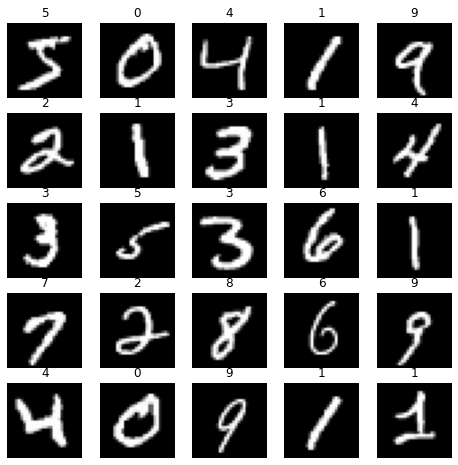

In [5]:
data, target = next(iter(tmp_dataloader))
data_np = dict()
data_np['x'] = data.numpy()
data_np['y'] = target.numpy()
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(data_np['y'][i])
    plt.imshow(data_np['x'][i][0], cmap='gray')

In [6]:
data, target = next(iter(tmp_dataloader))
for ii in range(len(data)):
    pixels_flatted = data[ii].reshape(-1)
    rand_idx = torch.randperm(len(pixels_flatted))
    pixels_flatted = pixels_flatted[rand_idx]
    data[ii] = pixels_flatted.reshape(-1, 28, 28)

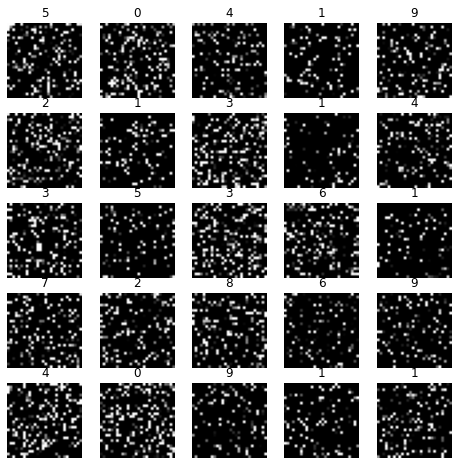

In [7]:
data_np = dict()
data_np['x'] = data.numpy()
data_np['y'] = target.numpy()
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(data_np['y'][i])
    plt.imshow(data_np['x'][i][0], cmap='gray')

In [8]:
data, target = next(iter(tmp_dataloader))
for ii in range(len(data)):
    pixels_flatted = data[ii].numpy().reshape(-1)
    pixels_flatted = torch.tensor([(1-p) for p in pixels_flatted], dtype=torch.float)
    data[ii] = pixels_flatted.reshape(-1, 28, 28)

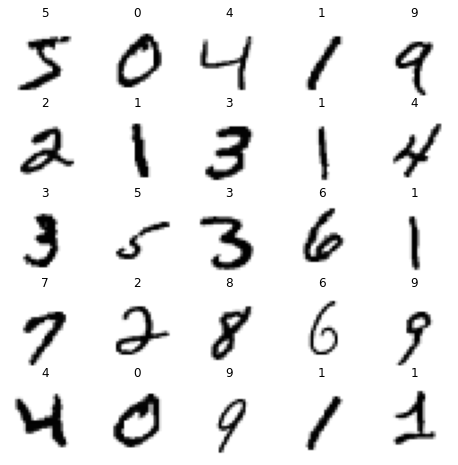

In [9]:
data_np = dict()
data_np['x'] = data.numpy()
data_np['y'] = target.numpy()
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(data_np['y'][i])
    plt.imshow(data_np['x'][i][0], cmap='gray')

In [83]:
data, target = next(iter(tmp_dataloader))
num_categories = torch.unique(target)
print("Categories: {}".format(num_categories))
percentage = 50
idx1 = np.array(random.sample(
    range(len(num_categories)), 
    int(percentage * 0.01 * len(num_categories))), dtype=np.int64)
print("Indexes to be used:\t{}".format(idx1))
idx2 = np.random.permutation(idx1)
print("Shuffled indexes:\t{}".format(idx2))

target_map = dict()
for ii in range(len(idx1)):
    target_map[idx1[ii]] = torch.tensor(idx2[ii])

print(target_map)

print(target[:15])
for ii in range(len(target)):
    if target[ii].item() in target_map.keys():
        target[ii] = target_map[target[ii].item()]
print(target[:15])

Categories: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Indexes to be used:	[1 6 4 3 0]
Shuffled indexes:	[4 6 1 0 3]
{1: tensor(4), 6: tensor(6), 4: tensor(1), 3: tensor(0), 0: tensor(3)}
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1])
tensor([5, 3, 1, 4, 9, 2, 4, 0, 4, 1, 0, 5, 0, 6, 4])


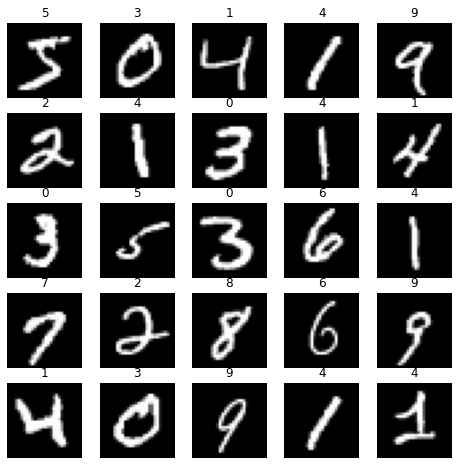

In [84]:
data_np = dict()
data_np['x'] = data.numpy()
data_np['y'] = target.numpy()
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.title(data_np['y'][i])
    plt.imshow(data_np['x'][i][0], cmap='gray')